## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [5]:
df_train.isna().sum(), df_val.isna().sum(), df_test.isna().sum()

(neighbourhood_group               0
 latitude                          0
 longitude                         0
 room_type                         0
 minimum_nights                    0
 number_of_reviews                 0
 reviews_per_month                 0
 calculated_host_listings_count    0
 availability_365                  0
 dtype: int64,
 neighbourhood_group               0
 latitude                          0
 longitude                         0
 room_type                         0
 minimum_nights                    0
 number_of_reviews                 0
 reviews_per_month                 0
 calculated_host_listings_count    0
 availability_365                  0
 dtype: int64,
 neighbourhood_group               0
 latitude                          0
 longitude                         0
 room_type                         0
 minimum_nights                    0
 number_of_reviews                 0
 reviews_per_month                 0
 calculated_host_listings_count    0
 availab

In [6]:
dict_train = df_train.fillna(0).to_dict(orient='records')
dict_val = df_val.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [7]:
dv.feature_names_

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
print(export_text(dt))

|--- feature_12 <= 0.50
|   |--- value: [4.29]
|--- feature_12 >  0.50
|   |--- value: [5.15]



In [10]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [11]:
print("Answer Question 1:", 'room_type')

Answer Question 1: room_type


## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [12]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=1, random_state=1)

In [13]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=1, random_state=1)

In [14]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [15]:
y_pred = rf.predict(X_val)

In [16]:
rmse(y_val, y_pred).round(3)

0.462

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

In [17]:
print("Answer Question 2:", '0.459')

Answer Question 2: 0.459


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [18]:
num_est = (np.linspace(10, 200, 20)).astype(int)
num_est

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

In [19]:
rmse_num_est = []
for n in num_est:
    rf = RandomForestRegressor(n_estimators=n, n_jobs=1, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse_num_est.append((n, rmse(y_val, y_pred).round(3)))
    print(n, rmse(y_val, y_pred).round(3))

10 0.462
20 0.448
30 0.446
40 0.444
50 0.442
60 0.442
70 0.441
80 0.441
90 0.441
100 0.44
110 0.439
120 0.439
130 0.439
140 0.439
150 0.439
160 0.439
170 0.439
180 0.439
190 0.439
200 0.439


In [20]:
df_rmse_num_est = pd.DataFrame(rmse_num_est, columns=['n_est', 'rmse'])
df_rmse_num_est.head(3)

,n_est,rmse
0,10,0.462
1,20,0.448
2,30,0.446


In [21]:
df_rmse_num_est.to_csv('q3_df_rmse_num_est.csv', index=False)

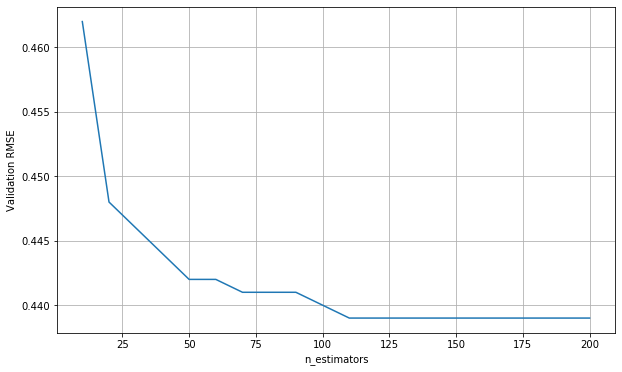

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df_rmse_num_est.n_est, df_rmse_num_est.rmse)
plt.xlabel('n_estimators')
plt.ylabel('Validation RMSE')
plt.grid()
plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

In [23]:
print("Answer Question 3:", '120')

Answer Question 3: 120


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [24]:
max_depth = (np.linspace(10, 25, 4)).astype(int)
num_est = (np.linspace(10, 200, 20)).astype(int)

In [25]:
max_depth

array([10, 15, 20, 25])

In [26]:
num_est

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

In [27]:
rmse_depth_ests = []

for d in max_depth:
    print('depth:', d)
    for n in num_est:
        rf = RandomForestRegressor(max_depth=d, n_estimators=n, n_jobs=1, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse_depth_ests.append((d, n, rmse(y_val, y_pred).round(3)))
        print(n, rmse(y_val, y_pred).round(3))
    print()

depth: 10
10 0.446
20 0.442
30 0.441
40 0.441
50 0.441
60 0.441
70 0.441
80 0.441
90 0.44
100 0.44
110 0.44
120 0.44
130 0.44
140 0.44
150 0.44
160 0.44
170 0.44
180 0.44
190 0.44
200 0.44

depth: 15
10 0.45
20 0.441
30 0.44
40 0.439
50 0.438
60 0.438
70 0.437
80 0.437
90 0.437
100 0.437
110 0.436
120 0.436
130 0.436
140 0.436
150 0.436
160 0.436
170 0.436
180 0.436
190 0.436
200 0.436

depth: 20
10 0.458
20 0.446
30 0.443
40 0.442
50 0.441
60 0.44
70 0.44
80 0.44
90 0.439
100 0.439
110 0.438
120 0.438
130 0.438
140 0.438
150 0.438
160 0.438
170 0.438
180 0.438
190 0.438
200 0.438

depth: 25
10 0.461
20 0.447
30 0.445
40 0.443
50 0.442
60 0.442
70 0.441
80 0.441
90 0.44
100 0.44
110 0.439
120 0.439
130 0.439
140 0.439
150 0.439
160 0.439
170 0.439
180 0.439
190 0.439
200 0.439



In [28]:
df_rmse_depth_ests = pd.DataFrame(rmse_depth_ests, columns=['depth', 'n_est', 'rmse'])
df_rmse_depth_ests.head()

,depth,n_est,rmse
0,10,10,0.446
1,10,20,0.442
2,10,30,0.441
3,10,40,0.441
4,10,50,0.441


In [29]:
df_rmse_depth_ests.to_csv('q4_df_rmse_depth_ests.csv', index=False)

In [30]:
min_rmse = df_rmse_depth_ests['rmse'].min()
min_rmse

0.436

In [31]:
df_rmse_depth_ests[df_rmse_depth_ests['rmse'] == min_rmse]

,depth,n_est,rmse
30,15,110,0.436
31,15,120,0.436
32,15,130,0.436
33,15,140,0.436
34,15,150,0.436
35,15,160,0.436
36,15,170,0.436
37,15,180,0.436
38,15,190,0.436
39,15,200,0.436


In [32]:
d10_rmse = df_rmse_depth_ests[df_rmse_depth_ests['depth'] == 10].rmse
d15_rmse = df_rmse_depth_ests[df_rmse_depth_ests['depth'] == 15].rmse
d20_rmse = df_rmse_depth_ests[df_rmse_depth_ests['depth'] == 20].rmse
d25_rmse = df_rmse_depth_ests[df_rmse_depth_ests['depth'] == 25].rmse

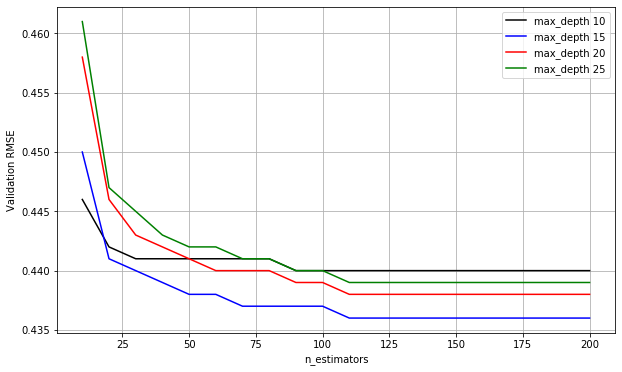

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(num_est, d10_rmse, color='black', label='max_depth 10')
plt.plot(num_est, d15_rmse, color='blue', label='max_depth 15')
plt.plot(num_est, d20_rmse, color='red', label='max_depth 20')
plt.plot(num_est, d25_rmse, color='green', label='max_depth 25')
plt.xlabel('n_estimators')
plt.ylabel('Validation RMSE')
plt.grid()
plt.legend()
plt.show()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

In [34]:
print("Answer Question 4:", '15')

Answer Question 4: 15


## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [35]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=1, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=1, random_state=1)

In [36]:
feature_importance = dict(zip(dv.feature_names_, rf.feature_importances_))
dict(sorted(feature_importance.items(), key=lambda x:x[1], reverse=True))

{'room_type=Entire home/apt': 0.3918981936917194,
 'longitude': 0.154100959574963,
 'latitude': 0.1527753537940021,
 'availability_365': 0.07626394738694817,
 'reviews_per_month': 0.05443038773303107,
 'minimum_nights': 0.053251917646480164,
 'number_of_reviews': 0.04159424150071029,
 'neighbourhood_group=Manhattan': 0.034047271823485964,
 'calculated_host_listings_count': 0.03010192548517813,
 'room_type=Shared room': 0.0050228413015867635,
 'room_type=Private room': 0.004032027763645291,
 'neighbourhood_group=Queens': 0.0011660990169743996,
 'neighbourhood_group=Brooklyn': 0.0009659595374179883,
 'neighbourhood_group=Bronx': 0.00026484584916173826,
 'neighbourhood_group=Staten Island': 8.4027894695538e-05}

In [37]:
feature_imp = list(zip(dv.feature_names_, rf.feature_importances_))

df_feature_imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
df_feature_imp = df_feature_imp.sort_values(by='importance', ascending=False)
df_feature_imp

,feature,importance
12,room_type=Entire home/apt,0.391898
3,longitude,0.154101
2,latitude,0.152775
0,availability_365,0.076264
11,reviews_per_month,0.054430
4,minimum_nights,0.053252
10,number_of_reviews,0.041594
7,neighbourhood_group=Manhattan,0.034047
1,calculated_host_listings_count,0.030102
14,room_type=Shared room,0.005023


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

In [38]:
print("Answer Question 5:", 'room_type=Entire home/apt')

Answer Question 5: room_type=Entire home/apt


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [39]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    cols = ['num_round', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=cols)
    
    return df_results

In [40]:
import xgboost as xgb

In [41]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [42]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [43]:
rmse_eta = {}
scores_eta = {}

In [44]:
%%capture output

eta = 0.3

xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [45]:
key = 'eta=%s' % (xgb_params['eta'])
scores_eta[key] = parse_xgb_output(output)
y_pred = model.predict(dval)
rmse_eta[key] = rmse(y_val, y_pred).round(3)

In [46]:
rmse_eta

{'eta=0.3': 0.436}

In [47]:
%%capture output

eta = 0.1

xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [48]:
key = 'eta=%s' % (xgb_params['eta'])
scores_eta[key] = parse_xgb_output(output)
y_pred = model.predict(dval)
rmse_eta[key] = rmse(y_val, y_pred).round(3)

In [49]:
rmse_eta

{'eta=0.3': 0.436, 'eta=0.1': 0.432}

In [50]:
%%capture output

eta = 0.01

xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [51]:
key = 'eta=%s' % (xgb_params['eta'])
scores_eta[key] = parse_xgb_output(output)
y_pred = model.predict(dval)
rmse_eta[key] = rmse(y_val, y_pred).round(3)

In [52]:
rmse_eta

{'eta=0.3': 0.436, 'eta=0.1': 0.432, 'eta=0.01': 1.63}

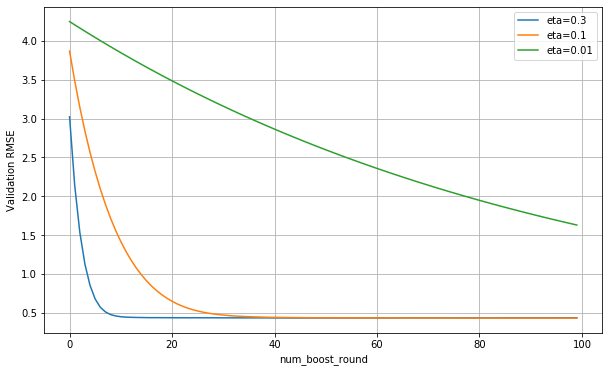

In [53]:
plt.figure(figsize=(10, 6))
for key, df_score in scores_eta.items():
    plt.plot(df_score.num_round, df_score.val_rmse, label=key)
plt.xlabel('num_boost_round')
plt.ylabel('Validation RMSE')
plt.legend()
plt.grid()

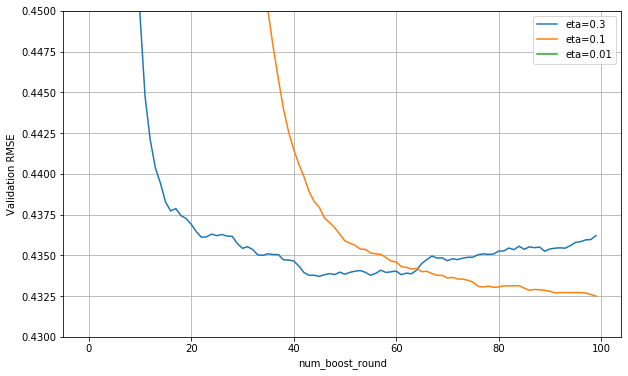

In [54]:
plt.figure(figsize=(10,6))
for key, df_score in scores_eta.items():
    plt.plot(df_score.num_round, df_score.val_rmse, label=key)
plt.ylim(0.43, 0.45)
plt.xlabel('num_boost_round')
plt.ylabel('Validation RMSE')
plt.legend()
plt.grid()

Now change `eta` first to `0.1` and then to `0.01`

In [55]:
# eta = [0.3, 0.1, 0.01]: all done above

In [56]:
dict(sorted(rmse_eta.items(), key=lambda x:x[1], reverse=False))

{'eta=0.1': 0.432, 'eta=0.3': 0.436, 'eta=0.01': 1.63}

In [57]:
df_rmse_eta = pd.DataFrame.from_dict(rmse_eta, orient='index', columns=['rmse'])
df_rmse_eta.sort_values(by='rmse', ascending=True)

,rmse
eta=0.1,0.432
eta=0.3,0.436
eta=0.01,1.630


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

In [58]:
print("Answer Question 6:", '0.1')

Answer Question 6: 0.1


## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

